![Partners](../images/partners.png)

# Renewable Energy Plants

In this notebook we will use the Renewable Power Plants databae (RePP) Africa that was implemented by the University of Tubingen in 2023 [1]. This is a spatial database for existing and proposed power plans (solar, wind and hydro) in Africa. The database contains information on the location, capacity, country and construction status. 

* Link to viewer: https://www.repp.geo.uni-tuebingen.de/
* Link to paper: https://www.nature.com/articles/s41597-022-01922-1

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import numpy as np
from pathlib import Path
import folium
from folium import plugins

import warnings
warnings.filterwarnings("ignore")

In [3]:
gdf = gpd.read_file("../data/renewable-energy-data/RePP/RePP_short_FeaturesToJSON.geojson")
gdf.head()

,OBJECTID,RE_source,ID,lat,lon,country,HPP_name,stat_ele,stat_inf,g_cap_mw,g_size,type,first_o_start,Last_edit__DD_MM_YYYY__HH_MM__UTC_1__,geometry
0,1,Hydro power,10018,4.072917,10.692717,Cameroon,Grand Eweng,P,P,1800.0,very large,Reservoir,2027.0,20.09.2022; 11:42,POINT (10.69272 4.07292)
1,2,Hydro power,10033,5.081279,10.827113,Cameroon,Noun-Wouri,P,P,1200.0,very large,Reservoir,NaN,13.10.2022; 13:59,POINT (10.82711 5.08128)
2,3,Hydro power,10052,-4.785417,14.856250,"Congo, Rep.",Kiniangui,P,P,1968.0,very large,,NaN,20.10.2022; 22:47,POINT (14.85625 -4.78542)
3,4,Hydro power,10103,-5.541800,13.541800,DR Congo,Inga IV,P,P,7180.0,very large,Reservoir,2030.0,21.09.2022; 08:28,POINT (13.5418 -5.5418)
4,5,Hydro power,10104,-5.541800,13.541800,DR Congo,Inga V,P,P,6970.0,very large,Reservoir,2030.0,20.10.2022; 13:49,POINT (13.5418 -5.5418)


In [4]:
icpac_countries = [
    "Burundi",
    "Djibouti",
    "Eritrea",
    "Ethiopia",
    "Kenya",
    "Rwanda",
    "Somalia",
    "South Sudan",
    "Sudan",
    "Tanzania",
    "Uganda"
]

gdf_icpac = gdf[gdf["country"].isin([c for c in icpac_countries])]
gdf_icpac.head()

,OBJECTID,RE_source,ID,lat,lon,country,HPP_name,stat_ele,stat_inf,g_cap_mw,g_size,type,first_o_start,Last_edit__DD_MM_YYYY__HH_MM__UTC_1__,geometry
10,11,Hydro power,10208,11.214583,35.093056,Ethiopia,Grand Ethiopian Renaissance Dam (Gerd),U,U,4875.0,very large,Reservoir,NaN,21.09.2022; 09:10,POINT (35.09306 11.21458)
11,12,Hydro power,10209,6.627805,36.602805,Ethiopia,Koysha (Gilgel Gibe IV),U,U,2200.0,very large,Reservoir,2025.0,15.10.2022; 16:41,POINT (36.6028 6.6278)
12,13,Hydro power,10211,10.072917,35.544080,Ethiopia,Mendya,P,P,1700.0,very large,Reservoir,NaN,15.10.2022; 16:41,POINT (35.54408 10.07292)
13,14,Hydro power,10212,9.004487,36.152083,Ethiopia,Bekoabo,P,P,2000.0,very large,Reservoir,2028.0,21.09.2022; 09:10,POINT (36.15208 9.00449)
14,15,Hydro power,10217,6.847627,37.302083,Ethiopia,Gilgel Gibe III,O,E,1870.0,very large,Reservoir,2014.0,21.09.2022; 09:10,POINT (37.30208 6.84763)


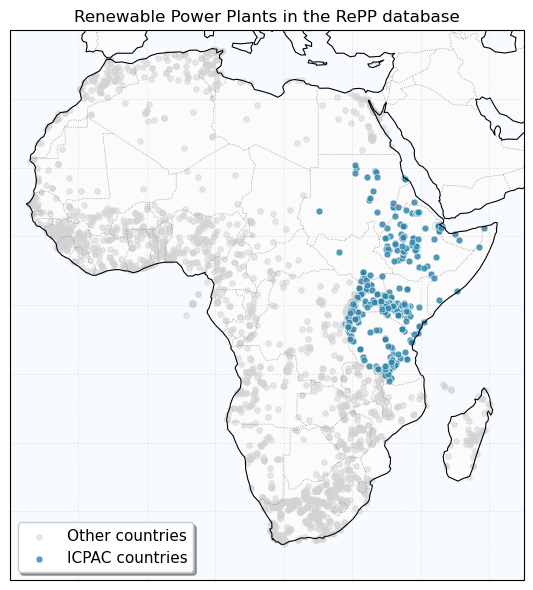

In [6]:
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines(linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='gray')
ax.add_feature(cartopy.feature.LAND, facecolor='#f5f5f5', alpha=0.3)
ax.add_feature(cartopy.feature.OCEAN, facecolor='#e6f2ff', alpha=0.3)
gdf.plot(ax=ax, alpha=0.5, color="#d3d3d3", markersize=15, label="Other countries")
gdf_icpac.plot(ax=ax, alpha=0.8, color="#2E86AB", markersize=25, edgecolor='white', linewidth=0.5, label="ICPAC countries")
ax.set_extent([-20, 55, -40, 40], crs=ccrs.PlateCarree())
ax.set_title("Renewable Power Plants in the RePP database")
ax.legend(loc='lower left', frameon=True, fancybox=True, shadow=True, fontsize=11)
ax.gridlines(draw_labels=False, linewidth=0.5, alpha=0.3, linestyle='--')
plt.tight_layout()


## Capacity Analysis by Country and Energy Type

Let's analyze the installed capacity across ICPAC countries for different renewable energy sources.

In [7]:
# Filter for operating plants only
gdf_operating = gdf_icpac[gdf_icpac.stat_ele == "O"]

# Group by country and energy source to get total capacity
capacity_by_country = gdf_operating.groupby(['country', 'RE_source'])['g_cap_mw'].sum().reset_index()

The database includes two key status columns:

- **`stat_ele`** (Electricity Generation Status): Indicates whether a power plant is currently producing electricity
  - **O** = Operating (actively generating electricity)
  - **NO** = Not Operating (facility exists but temporarily not producing electricity)
  - **U** = Under Construction
  - **P** = Proposed

- **`stat_inf`** (Infrastructure Status): Indicates the physical existence state of the power plant
  - **E** = Existing (facility is built and present)
  - **U** = Under Construction (facility is being built)
  - **P** = Proposed (planned but not yet built)

**Example:** A plant can have `stat_inf = "E"` (the infrastructure exists) but `stat_ele = "NO"` (temporarily not operating due to maintenance, damage, or other reasons).

In [ ]:

# Prepare data for operating and planned plants
gdf_planned = gdf_icpac[gdf_icpac.stat_ele.isin(["U", "P"])]  # Under construction or Proposed

capacity_planned = gdf_planned.groupby(['country', 'RE_source'])['g_cap_mw'].sum().reset_index()

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Color scheme for energy types
colors = {'Solar power': '#FDB462', 'Wind power': '#80B1D3', 'Hydro power': '#8DD3C7'}

# 1. Operating Capacity by Country - Stacked Bar Chart
pivot_data = capacity_by_country.pivot(index='country', columns='RE_source', values='g_cap_mw').fillna(0)
pivot_data.plot(kind='barh', stacked=True, ax=ax1, 
                color=[colors.get(x, '#999999') for x in pivot_data.columns],
                edgecolor='white', linewidth=0.5)
ax1.set_xlabel('Installed Capacity (MW)')
ax1.set_ylabel('Country')
ax1.set_title('Operating Capacity by Country', pad=15)
ax1.legend(title='Energy Type', loc='lower right', frameon=True, fontsize=9)
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)

# 2. Operating vs Planned Comparison

# Aggregate data by energy type
operating_totals = capacity_by_country.groupby('RE_source')['g_cap_mw'].sum()
planned_totals = capacity_planned.groupby('RE_source')['g_cap_mw'].sum()

# Ensure all energy types are represented
all_types = list(colors.keys())
operating_vals = [operating_totals.get(t, 0) for t in all_types]
planned_vals = [planned_totals.get(t, 0) for t in all_types]

x_pos = np.arange(len(all_types))
width = 0.35

bars1 = ax2.bar(x_pos - width/2, operating_vals, width, label='Operating',
                color=[colors[t] for t in all_types], alpha=0.8, edgecolor='white', linewidth=1.5)
bars2 = ax2.bar(x_pos + width/2, planned_vals, width, label='Planned/Under Construction',
                color=[colors[t] for t in all_types], alpha=0.4, edgecolor='gray', linewidth=1.5, hatch='//')

ax2.set_ylabel('Capacity (MW)')
ax2.set_xlabel('Energy Type')
ax2.set_title('Operating vs Planned Capacity', pad=15)
ax2.set_xticks(x_pos)
ax2.set_xticklabels([t.replace(' power', '') for t in all_types], fontsize=10)
ax2.legend(fontsize=9)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_axisbelow(True)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('ICPAC Region Renewable Energy Capacity', fontweight='bold')
plt.tight_layout()
plt.show()

## Explore specific country data

In [ ]:
# Select country to visualize
selected_country = "Kenya"  # Change this to any country from: Burundi, Djibouti, Eritrea, Ethiopia, Rwanda, Somalia, South Sudan, Sudan, Tanzania, Uganda

# Filter data for selected country
country_data = gdf_icpac[gdf_icpac.country == selected_country]

if len(country_data) > 0:
    # Calculate center of the country using coordinates directly
    center_lat = country_data.geometry.y.mean()
    center_lon = country_data.geometry.x.mean()
    
    # Create map
    m = folium.Map(location=[center_lat, center_lon], zoom_start=7, tiles='OpenStreetMap')
    
    # Color scheme matching the bar charts
    color_map = {
        'Solar power': '#FDB462',
        'Wind power': '#80B1D3',
        'Hydro power': '#8DD3C7'
    }
    
    # Add markers for each plant
    for idx, row in country_data.iterrows():
        # Get plant info
        plant_name = row.get('HPP_name', 'Unknown')
        energy_type = row['RE_source']
        capacity = row.get('g_cap_mw', 0)
        status = row.get('stat_ele', 'Unknown')
        
        # Create popup text
        popup_text = f"""
        <b>{plant_name}</b><br>
        Type: {energy_type}<br>
        Capacity: {capacity:.1f} MW<br>
        Status: {status}
        """
        
        # Add marker
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=6,
            popup=folium.Popup(popup_text, max_width=200),
            color='white',
            weight=1,
            fill=True,
            fillColor=color_map.get(energy_type, '#999999'),
            fillOpacity=0.7
        ).add_to(m)
    
    # Add title
    title_html = f'''
    <div style="position: fixed; 
                top: 10px; left: 50px; width: 300px; height: 50px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:16px; font-weight: bold; padding: 10px">
    Renewable Energy Plants - {selected_country}
    </div>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    display(m)
else:
    print(f"No data available for {selected_country}")

In [ ]:
# list of all operating solar power plants in the selected country   
country_data[(country_data['RE_source'] == 'Solar power') & (country_data['stat_ele'] == 'O')].sort_values(by='g_cap_mw', ascending=False)

In [ ]:
# list of all operating wind power plants in the selected country
country_data[(country_data['RE_source'] == 'Wind power') & (country_data['stat_ele'] == 'O')].sort_values(by='g_cap_mw', ascending=False)

In [ ]:
# list of all operation hydro power plants in the selected country
country_data[(country_data['RE_source'] == 'Hydro power') & (country_data['stat_ele'] == 'O')].sort_values(by='g_cap_mw', ascending=False)

## References
[1] Peters, R., Berlekamp, J., Tockner, K., & Zarfl, C. (2023). RePP Africa–a georeferenced and curated database on existing and proposed wind, solar, and hydropower plants. Scientific Data, 10(1), 16.